In [1]:
import numpy as np
import matplotlib.pyplot as plt
from generate_magnetic_field import get_mag_field
import torch.nn as nn
import torch

In [2]:
# genrate coordinate mesh 
x_data_points = 11
x_array = np.linspace(-1,1,x_data_points)
x_array
xv,yv,zv = np.meshgrid(x_array,x_array,x_array,indexing='ij')

In [3]:
# create BV mask 
xyv_mask    = ((xv==-1) + (xv==0) + (xv==1)) * ((yv==-1) + (yv==0) + (yv==1))
zv_mask     = (zv==-1) + (zv ==1) + (zv==0)
center_mask = (xv==0)*(yv==0)*(zv==0)
bv_mask     = (xyv_mask) * (zv_mask)* (~center_mask)

In [4]:
# calculate B(B_x,B_y,B_z) field at x,y,z meshgrid 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bv = B[bv_mask]                     # get the BV (26 values)
B[~bv_mask] = 0                     # set phyics BV =0 

In [5]:
# bv coordinates 
Bv_coords = np.array([xv[bv_mask],yv[bv_mask],zv[bv_mask]]).T
Bv_coords = torch.from_numpy(Bv_coords).type(torch.float32)      # convert to torch.tensor

In [6]:
# physics BV coords 
PBv_coords = np.array([xv[~bv_mask],yv[~bv_mask],zv[~bv_mask]]).T
PBv_coords = torch.from_numpy(PBv_coords).type(torch.float32).requires_grad_(True)     
PBv_coords

tensor([[-1.0000, -1.0000, -0.8000],
        [-1.0000, -1.0000, -0.6000],
        [-1.0000, -1.0000, -0.4000],
        ...,
        [ 1.0000,  1.0000,  0.4000],
        [ 1.0000,  1.0000,  0.6000],
        [ 1.0000,  1.0000,  0.8000]], requires_grad=True)

In [7]:
# Bvs (magentic field at boundaries)
Bv = torch.from_numpy(Bv).type(torch.float32)

In [8]:
class FFNN(nn.Module):
    def __init__(self,input_features,output_features,hidden_feature):
        super().__init__()
        self.layer_1 = nn.Linear(input_features,hidden_feature)
        self.layer_2 = nn.Linear(hidden_feature,hidden_feature)
        self.layer_3 = nn.Linear(hidden_feature,hidden_feature)
        self.layer_4 = nn.Linear(hidden_feature,output_features)
        self.activation = nn.Tanh()
        
    def forward(self,x):
        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        x = self.activation(self.layer_3(x))
        x = self.layer_4(x)
        return x 
        

In [9]:
model = FFNN(3,3,12)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [10]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    B_pred = model(Bv_coords) # prediction from FFNN 
    loss = loss_fn(B_pred,Bv) # data loss, using the BVs 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100 ==0:
        print(f'epoch:{epoch} | train loss:{loss:.3f}')
    

epoch:0 | train loss:0.634
epoch:100 | train loss:0.004
epoch:200 | train loss:0.001
epoch:300 | train loss:0.001
epoch:400 | train loss:0.000
epoch:500 | train loss:0.000


epoch:600 | train loss:0.000
epoch:700 | train loss:0.000
epoch:800 | train loss:0.000
epoch:900 | train loss:0.000


In [11]:
# test the PINN model 

z = torch.from_numpy(np.array([[0,0,i] for i in np.linspace(-1,1,11)])).type(torch.float32)
Bz_pred = model(z)
Bz_pred = Bz_pred.detach().numpy()

z_axis_mask = (xv==0) * (yv==0)     # mask to select data along z axis 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bz = B[z_axis_mask]                 # Bz along z axis 

Text(0, 0.5, '$B_y$')

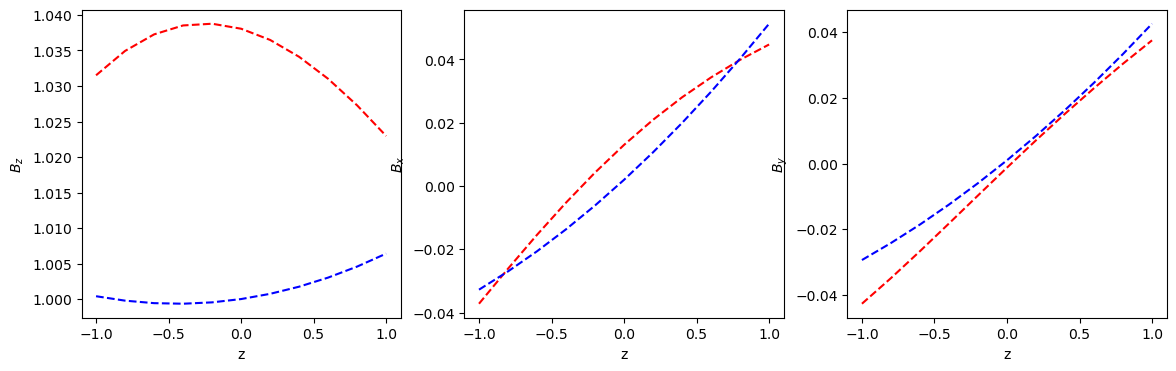

In [12]:
# plot the magnetic field 
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(z[:,2],Bz_pred[:,2],'r--',label='pred')
ax1.plot(z[:,2],Bz[:,2],'b--',label='actaul')
ax1.set_xlabel('z')
ax1.set_ylabel(r'$B_z$')

ax2.plot(z[:,2],Bz_pred[:,0],'r--',label='pred')
ax2.plot(z[:,2],Bz[:,0],'b--',label='actaul')
ax2.set_xlabel('z')
ax2.set_ylabel(r'$B_x$')

ax3.plot(z[:,2],Bz_pred[:,1],'r--',label='pred')
ax3.plot(z[:,2],Bz[:,1],'b--',label='actaul')
ax3.set_xlabel('z')
ax3.set_ylabel(r'$B_y$')

In [13]:
Bhp = model(PBv_coords)
Bhp

tensor([[-5.5029e-02, -9.5385e-03,  9.2538e-01],
        [-4.6396e-02, -2.1389e-03,  9.2602e-01],
        [-3.7712e-02,  5.6401e-03,  9.2595e-01],
        ...,
        [ 3.6125e-02, -1.1211e-02,  1.0793e+00],
        [ 4.2034e-02, -5.3021e-03,  1.0805e+00],
        [ 4.7351e-02,  3.6730e-04,  1.0809e+00]], grad_fn=<AddmmBackward0>)

In [14]:
torch.autograd.grad(Bhp,PBv_coords,torch.ones_like(Bhp))[0].shape

torch.Size([1305, 3])

### Why we didn't get [batch_size,output_dim,input_dim]?

* Jacobian matrix find the gradients and it is normally has shape of [output_dim,input_dim]

* But when we called **torch.autograd.grad** we get [batch_size,input_dim], this is because the grad function sums the gradients along the "output dim"

* To get the full Jacobian matrix we can use **torch.autograd.functional.jacobian()**, this returns [batch_size,output_dim,batch_size,input_dim]

In [15]:
#using torch.autograd.functional.jacobian
B_jacob = torch.autograd.functional.jacobian(lambda t:model(t),PBv_coords) # (batch_size, output_dim, batch_size, input_dim)
#the off-diagonal elements of 0th and 2nd dimension are all zero. So we remove them
B_grad  = torch.diagonal(B_jacob,offset=0,dim1=0,dim2=2)                   # (output_dim, input_dim, batch_size)
B_grad  = B_grad.permute(2,0,1)                                            # (batch_size, output_dim, input_dim)    

In [16]:
B_grad

tensor([[[ 2.8351e-02,  5.6397e-03,  4.2888e-02],
         [-4.7384e-03, -2.5248e-02,  3.5881e-02],
         [ 5.9390e-02,  5.3002e-02,  5.1353e-03]],

        [[ 2.8834e-02,  7.5334e-03,  4.3364e-02],
         [-3.2346e-03, -2.5257e-02,  3.8035e-02],
         [ 5.8081e-02,  5.5199e-02,  1.3716e-03]],

        [[ 2.8985e-02,  9.2559e-03,  4.3403e-02],
         [-1.5679e-03, -2.5316e-02,  3.9658e-02],
         [ 5.5795e-02,  5.7657e-02, -2.0601e-03]],

        ...,

        [[ 8.8243e-03, -8.5691e-03,  3.1088e-02],
         [ 2.3545e-05, -2.3083e-02,  3.0162e-02],
         [ 1.3004e-02, -1.0668e-02,  8.6366e-03]],

        [[ 8.7004e-03, -8.8052e-03,  2.8032e-02],
         [ 1.8535e-05, -2.5106e-02,  2.8931e-02],
         [ 1.5194e-02, -7.2500e-03,  4.1785e-03]],

        [[ 8.6404e-03, -8.8629e-03,  2.5172e-02],
         [-9.4667e-05, -2.6989e-02,  2.7783e-02],
         [ 1.7606e-02, -3.9473e-03, -4.3954e-04]]])

In [17]:
# implement del.B = 0 
del_dot_B = torch.diagonal(B_grad,offset=0,dim1=1,dim2=2).sum(dim=1)

In [18]:
# implement del.cross.B 
del_cross_B = B_grad[:,0,1] + B_grad[:,1,0] + B_grad[:,0,2] + B_grad[:,2,0] + B_grad[:,1,2] + B_grad[:,2,1]
del_cross_B

tensor([0.1921, 0.1990, 0.2042,  ..., 0.0550, 0.0561, 0.0577])

In [24]:
# physics infromed NN 

phy_model = FFNN(3,3,12)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(phy_model.parameters(),lr=0.001)

epochs = 500

for epoch in range(epochs):
    phy_model.train()
    # BCs 
    B_pred = phy_model(Bv_coords) # prediction from FFNN 
    bv_loss = loss_fn(B_pred,Bv) # data loss, using the BVs 
    
    # use physics BCs 
    B_jacob = torch.autograd.functional.jacobian(lambda t:phy_model(t),PBv_coords)
    B_grad  = torch.diagonal(B_jacob,offset=0,dim1=0,dim2=2)                   
    B_grad  = B_grad.permute(2,0,1)
    
    # implement del.B = 0 
    del_dot_B = torch.diagonal(B_grad,offset=0,dim1=1,dim2=2).sum(dim=1)
    # implement del.cross.B 
    del_cross_B = B_grad[:,0,1] + B_grad[:,1,0] + B_grad[:,0,2] + B_grad[:,2,0] + B_grad[:,1,2] + B_grad[:,2,1]
    # physics loss 
    phy_loss = 1e-3 * (torch.mean(del_dot_B**2) + torch.mean(del_cross_B**2))
    # total loss 
    loss = bv_loss + phy_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%50 ==0:
        print(f'epoch:{epoch} | train loss:{loss:.5f}')
    

epoch:0 | train loss:0.34971
epoch:50 | train loss:0.06328
epoch:100 | train loss:0.00132
epoch:150 | train loss:0.00072
epoch:200 | train loss:0.00059
epoch:250 | train loss:0.00052
epoch:300 | train loss:0.00045
epoch:350 | train loss:0.00040
epoch:400 | train loss:0.00036
epoch:450 | train loss:0.00033


In [25]:
# test the PINN model 

z = torch.from_numpy(np.array([[0,0,i] for i in np.linspace(-1,1,11)])).type(torch.float32)
Bz_pred = phy_model(z)
Bz_pred = Bz_pred.detach().numpy()
Bz_pred

array([[-0.0448485 , -0.04058418,  1.0113218 ],
       [-0.03591429, -0.03401045,  1.0224423 ],
       [-0.02627778, -0.02695999,  1.0329086 ],
       [-0.01615344, -0.01951588,  1.0420183 ],
       [-0.00579658, -0.01178132,  1.0490882 ],
       [ 0.00452164, -0.00387105,  1.0535036 ],
       [ 0.01453996,  0.00409884,  1.0547565 ],
       [ 0.02403021,  0.01201968,  1.0524722 ],
       [ 0.03281286,  0.01979717,  1.0464218 ],
       [ 0.04076443,  0.02735547,  1.036524  ],
       [ 0.04781711,  0.03463884,  1.0228403 ]], dtype=float32)

In [34]:
z_axis_mask = (xv==0) * (yv==0)     # mask to select data along z axis 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bz = B[z_axis_mask]                 # Bz along z axis 
Bz

array([[-3.270000e-02, -2.940000e-02,  1.000400e+00],
       [-2.692800e-02, -2.421600e-02,  9.997760e-01],
       [-2.057200e-02, -1.858400e-02,  9.994240e-01],
       [-1.363200e-02, -1.250400e-02,  9.993440e-01],
       [-6.108000e-03, -5.976000e-03,  9.995360e-01],
       [ 2.000000e-03,  1.000000e-03,  1.000000e+00],
       [ 1.069200e-02,  8.424000e-03,  1.000736e+00],
       [ 1.996800e-02,  1.629600e-02,  1.001744e+00],
       [ 2.982800e-02,  2.461600e-02,  1.003024e+00],
       [ 4.027200e-02,  3.338400e-02,  1.004576e+00],
       [ 5.130000e-02,  4.260000e-02,  1.006400e+00]])

Text(0, 0.5, '$B_y$')

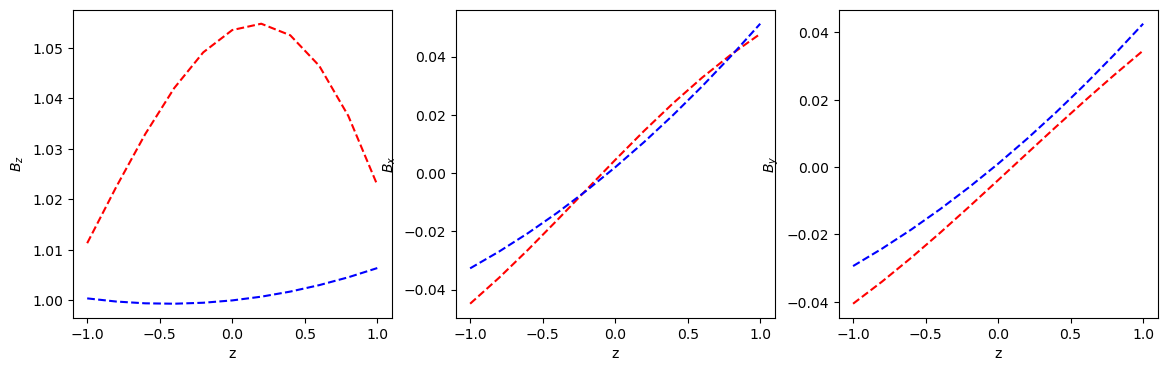

In [33]:
# plot the magnetic field 
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(z[:,2],Bz_pred[:,2],'r--',label='pred')
ax1.plot(z[:,2],Bz[:,2],'b--',label='actaul')
ax1.set_xlabel('z')
ax1.set_ylabel(r'$B_z$')

ax2.plot(z[:,2],Bz_pred[:,0],'r--',label='pred')
ax2.plot(z[:,2],Bz[:,0],'b--',label='actaul')
ax2.set_xlabel('z')
ax2.set_ylabel(r'$B_x$')

ax3.plot(z[:,2],Bz_pred[:,1],'r--',label='pred')
ax3.plot(z[:,2],Bz[:,1],'b--',label='actaul')
ax3.set_xlabel('z')
ax3.set_ylabel(r'$B_y$')